### Packages importing

In [1]:
import numpy as np
import pandas as pd

import nltk
import string

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

### Load IMDB dataset

In [2]:
imdb_df = pd.read_csv(r'C:\Users\daria\Desktop\IMDB Dataset.csv')

In [3]:
imdb_df.head(5)

,review,sentiment
0,An excellent cast who do their best with an aw...,negative
1,A dreary and pointless bit of fluff (bloody fl...,negative
2,If the writer/director is reading this (and I ...,negative
3,This is a classic B type movie that you'd rath...,negative
4,A short review but...<br /><br />Avoid at all ...,negative


In [4]:
imdb_df.sentiment.value_counts()

positive    25000
negative     2502
Name: sentiment, dtype: int64

In [5]:
# Decoding sentiment variable
imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative': 1, 'positive': 0})

In [6]:
# Spliting data into training and test set
# stratify split was used because of unbalanced dependent variable (9% of negative reviews)
X_train, X_test, y_train, y_test = train_test_split(imdb_df['review'], 
                                                    imdb_df['sentiment'], 
                                                    test_size=0.3, 
                                                    stratify=imdb_df['sentiment'], 
                                                    random_state=789)

## Preprocessing

#### Tokenization and cleaning
* Removing non-digit and non-letter parts
* Removing standalone numbers (remove '100' from '100 pieces')
* Removing stop words (but keeping the word 'from')
* Another other text cleaning and standard processing

In [7]:
# Importing stop words set, keeping the word "from"
stop_words=set(stopwords.words("english"))
stop_words.remove('from')
# print(stop_words)

In [8]:
def my_tokenizer(reviews):
    
    def lemmatize_word(word, tag):
        wnl = WordNetLemmatizer()
        if tag.startswith("NN"):
            token = wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            token = wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            token = wnl.lemmatize(word, pos='a')
        else:
            token = word
        return token
    
    cleaned_tokens = []
    
    tokens = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(reviews)
    
    for word, tag in pos_tag(tokens):
        token = lemmatize_word(word, tag)
        if len(token) > 0 and token not in string.punctuation and not token.isdigit():
            cleaned_tokens.append(token.lower())

    return cleaned_tokens

In [9]:
# Spliting X_train into negative and positive reviews 
X_train_n = X_train[y_train[y_train == 1].index].copy()
X_train_p = X_train[y_train[y_train == 0].index].copy()

In [10]:
# Unigram Counts for negative reviews to EDA 
unigram_n_vectorizer = CountVectorizer(lowercase=True,stop_words=stop_words,ngram_range=(1, 1),tokenizer = my_tokenizer)
X_train_n_unigram = unigram_n_vectorizer.fit_transform(X_train_n)
neg_rev_features_cnt = dict(zip(unigram_n_vectorizer.get_feature_names(), X_train_n_unigram.sum(axis=0).tolist()[0]))

C:\Users\daria\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['win'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [11]:
# Unigram Counts for negative reviews to EDA 
unigram_p_vectorizer = CountVectorizer(lowercase=True,stop_words=stop_words,ngram_range=(1, 1),tokenizer = my_tokenizer)
X_train_p_unigram = unigram_p_vectorizer.fit_transform(X_train_p)
pos_rev_features_cnt = dict(zip(unigram_p_vectorizer.get_feature_names(), X_train_p_unigram.sum(axis=0).tolist()[0]))

C:\Users\daria\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['win'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<hr>

In [12]:
# Unigram Counts
unigram_vectorizer = CountVectorizer(lowercase=True,stop_words=stop_words,ngram_range=(1, 1),tokenizer = my_tokenizer)
X_train_unigram = unigram_vectorizer.fit_transform(X_train)
X_test_unigram = unigram_vectorizer.transform(X_test)

# print(unigram_vectorizer.get_feature_names())

C:\Users\daria\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['win'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [13]:
# Unigram Tf-Idf
unigram_tf_idf_transformer = TfidfTransformer()
X_train_unigram_tf_idf  = unigram_tf_idf_transformer.fit_transform(X_train_unigram)
X_test_unigram_tf_idf  = unigram_tf_idf_transformer.transform(X_test_unigram)

In [14]:
# Bigram Counts
bigram_vectorizer = CountVectorizer(lowercase=True,stop_words=stop_words,ngram_range=(1, 2),tokenizer = my_tokenizer)
X_train_bigram = bigram_vectorizer.fit_transform(X_train)
X_test_bigram = bigram_vectorizer.transform(X_test)

# print(bigram_vectorizer.get_feature_names())

C:\Users\daria\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['win'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [15]:
# Bigram Tf-Idf
bigram_tf_idf_transformer = TfidfTransformer()
X_train_bigram_tf_idf = bigram_tf_idf_transformer.fit_transform(X_train_bigram)
X_test_bigram_tf_idf  = bigram_tf_idf_transformer.transform(X_test_bigram)

## Objectives

### EDA

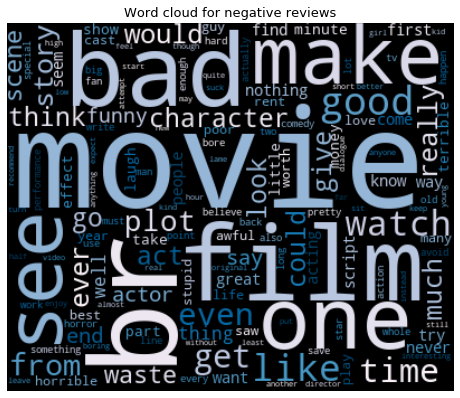

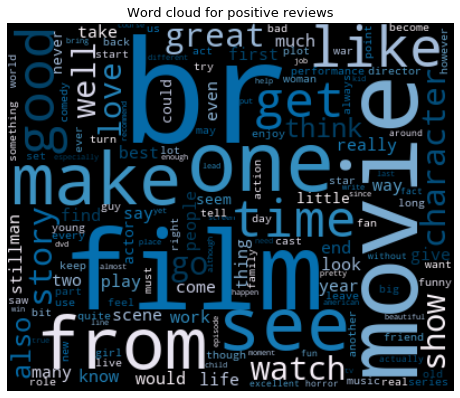

In [16]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
import matplotlib.pyplot as plt

# Function for generating word clouds
def generate_wordcloud(data,title):
    wc = WordCloud(width=400, height=330, max_words=150,colormap="PuBu").generate_from_frequencies(data)
    plt.figure(figsize=(8,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title('\n'.join(wrap(title,60)),fontsize=13)
    plt.show()

generate_wordcloud(neg_rev_features_cnt,'Word cloud for negative reviews'), 
generate_wordcloud(pos_rev_features_cnt,'Word cloud for positive reviews')

### Build a classifier 

Target variable is 'sentiment', build a classifier and assess its performance

In [17]:
def train_and_show_metrics(X: csr_matrix, y: np.array) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    valid_pred = clf.predict(X_valid)
    print('classification report - training set:\n', classification_report(y_train, train_pred, target_names=['positive', 'negative']))
    print('classification report - validation set:\n', classification_report(y_valid, valid_pred, target_names=['positive', 'negative']))
    print('Accuracy score - training set: ', accuracy_score(y_train, train_pred))
    print('Accuracy score - validation set: ', accuracy_score(y_valid, valid_pred))
    print('\nConfusion matrix - training set:\n', confusion_matrix(y_train, train_pred))
    print('\nConfusion matrix - validation set:\n', confusion_matrix(y_valid, valid_pred))
    return clf
    
def test_set_metrics(X: csr_matrix, y: np.array, clf, set_title):
    pred = clf.predict(X)
    print(classification_report(y, pred, target_names=['positive', 'negative']))
    print('Accuracy score - ' + set_title + ' set: ', accuracy_score(y, pred))
    print('\nConfusion matrix - ' + set_title + ' set:\n', confusion_matrix(y, pred))

Unigram performance

In [26]:
clf_u = train_and_show_metrics(X_train_unigram, y_train)

classification report - training set:
               precision    recall  f1-score   support

    positive       1.00      1.00      1.00     13125
    negative       0.99      1.00      0.99      1313

    accuracy                           1.00     14438
   macro avg       1.00      1.00      1.00     14438
weighted avg       1.00      1.00      1.00     14438

classification report - validation set:
               precision    recall  f1-score   support

    positive       0.98      0.98      0.98      4375
    negative       0.78      0.78      0.78       438

    accuracy                           0.96      4813
   macro avg       0.88      0.88      0.88      4813
weighted avg       0.96      0.96      0.96      4813

Accuracy score - training set:  0.999030336611719
Accuracy score - validation set:  0.9592769582381051

Confusion matrix - training set:
 [[13114    11]
 [    3  1310]]

Confusion matrix - validation set:
 [[4277   98]
 [  98  340]]


<hr>
unigram tf_idf performance

In [27]:
clf_u_tf_idf = train_and_show_metrics(X_train_unigram_tf_idf, y_train)

classification report - training set:
               precision    recall  f1-score   support

    positive       0.98      1.00      0.99     13125
    negative       0.99      0.79      0.88      1313

    accuracy                           0.98     14438
   macro avg       0.99      0.90      0.94     14438
weighted avg       0.98      0.98      0.98     14438

classification report - validation set:
               precision    recall  f1-score   support

    positive       0.96      1.00      0.98      4375
    negative       0.93      0.58      0.72       438

    accuracy                           0.96      4813
   macro avg       0.95      0.79      0.85      4813
weighted avg       0.96      0.96      0.95      4813

Accuracy score - training set:  0.98053747056379
Accuracy score - validation set:  0.9580303345107002

Confusion matrix - training set:
 [[13116     9]
 [  272  1041]]

Confusion matrix - validation set:
 [[4356   19]
 [ 183  255]]


<hr>
bigram performance

In [28]:
clf_b = train_and_show_metrics(X_train_bigram, y_train)

classification report - training set:
               precision    recall  f1-score   support

    positive       1.00      1.00      1.00     13125
    negative       1.00      1.00      1.00      1313

    accuracy                           1.00     14438
   macro avg       1.00      1.00      1.00     14438
weighted avg       1.00      1.00      1.00     14438

classification report - validation set:
               precision    recall  f1-score   support

    positive       0.97      0.99      0.98      4375
    negative       0.83      0.71      0.77       438

    accuracy                           0.96      4813
   macro avg       0.90      0.85      0.87      4813
weighted avg       0.96      0.96      0.96      4813

Accuracy score - training set:  1.0
Accuracy score - validation set:  0.9605235819655101

Confusion matrix - training set:
 [[13125     0]
 [    0  1313]]

Confusion matrix - validation set:
 [[4310   65]
 [ 125  313]]


<hr>
bigram tf_idf performance

In [29]:
clf_b_tf_idf = train_and_show_metrics(X_train_bigram_tf_idf, y_train)

classification report - training set:
               precision    recall  f1-score   support

    positive       0.99      1.00      0.99     13125
    negative       1.00      0.87      0.93      1313

    accuracy                           0.99     14438
   macro avg       0.99      0.93      0.96     14438
weighted avg       0.99      0.99      0.99     14438

classification report - validation set:
               precision    recall  f1-score   support

    positive       0.94      1.00      0.97      4375
    negative       0.97      0.33      0.50       438

    accuracy                           0.94      4813
   macro avg       0.95      0.67      0.73      4813
weighted avg       0.94      0.94      0.92      4813

Accuracy score - training set:  0.9880177309876714
Accuracy score - validation set:  0.9382921254934552

Confusion matrix - training set:
 [[13124     1]
 [  172  1141]]

Confusion matrix - validation set:
 [[4370    5]
 [ 292  146]]


<hr>

All four models have similar preformance statistics - accuracy in range from 0.98 to 1 on training set and from 0.94 to 0.96 on validation set. Unigram performance variant was chosen because of simultaneously high precision, recall and f1-score for nagative class on validation set.

Final model check on test set

In [30]:
test_set_metrics(X_test_unigram, y_test, clf_u, 'test')

              precision    recall  f1-score   support

    positive       0.98      0.97      0.97      7500
    negative       0.73      0.77      0.75       751

    accuracy                           0.95      8251
   macro avg       0.85      0.87      0.86      8251
weighted avg       0.95      0.95      0.95      8251

Accuracy score - test set:  0.9532177917828142

Confusion matrix - test set:
 [[7289  211]
 [ 175  576]]


Still very good performance

### Anomaly detection on 'review'

Analysis mostly based on the following article:

https://medium.com/datadriveninvestor/unsupervised-outlier-detection-in-text-corpus-using-deep-learning-41d4284a04c8

* Create a model to detect outliers/anomalies in this dataset

In [31]:
import multiprocessing

from collections import Counter
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from itertools import islice
from scipy.spatial.distance import cosine
from sklearn import utils as skl_utils
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

In [32]:
data = imdb_df.loc[:, ['review']].copy()

In [33]:
# Text cleaning steps (same as in sentiment analysis)
data.loc[:,'review'] = data.loc[:,'review'].map(lambda x: " ".join(my_tokenizer(x)))

In [34]:
data.head(5)

,review
0,an excellent cast who do their best with an aw...
1,a dreary and pointless bit of fluff bloody flu...
2,if the writer director be read this and i imag...
3,this be a classic b type movie that you d rath...
4,a short review but br br avoid at all cost a t...


In [35]:
# Convertion reviews into document vectors
class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['review']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['review']).split())
                                     for index, row in df_x.iterrows()]))

In [36]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(data)
doc2vec_vectors = doc2vec_tr.transform(data)

100%|████████████████████████████████████████████████████████████████████████| 27502/27502 [00:00<00:00, 679218.92it/s]


In [37]:
print(doc2vec_vectors)

[[-2.5038127e-04 -6.4069743e-04  8.7267894e-04 ...  1.5252135e-03
   5.6771334e-04  6.8449514e-04]
 [ 1.6123380e-03  1.3520101e-04 -1.5523674e-03 ... -1.4457358e-03
  -1.6273395e-03 -1.5065806e-04]
 [ 5.6485750e-04  6.1607752e-05  1.0837368e-03 ...  1.2960579e-03
   1.4156705e-03 -1.4423910e-03]
 ...
 [ 4.8478702e-04 -9.5444487e-04 -1.6608525e-03 ...  2.4979704e-04
   6.6147099e-04 -3.7121269e-04]
 [-1.8750133e-03 -1.2049609e-03 -2.5954298e-03 ... -3.7081582e-03
  -8.5516664e-04  2.0886767e-03]
 [ 1.3758589e-03 -1.0191274e-03 -1.5077890e-03 ... -1.3617153e-03
  -2.6335151e-04  1.4287044e-03]]


In [38]:
# Autoencoder Neural Network
auto_encoder = MLPRegressor(hidden_layer_sizes=(600, 150, 600,))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [39]:
print('Accuracy score: ', auto_encoder.score(predicted_vectors, doc2vec_vectors))

C:\Users\daria\Anaconda3\lib\site-packages\sklearn\base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Accuracy score:  0.8732949712440261


87% information of the input variables is successfully reconstructed

Pattern of loss function of the entire network


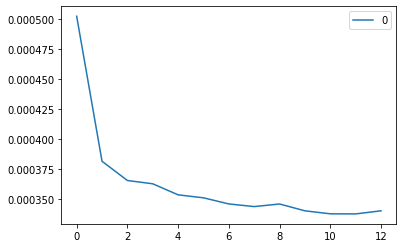

In [40]:
print('Pattern of loss function of the entire network')
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [41]:
def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(data)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=10):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Review cleaned:', data.iloc[index, 0])  
        print('\nReview raw: ', imdb_df.loc[index, 'review']) 
        print('\nCosine Sim Val :', consine_sim_val)
        print('---------------------------------')

* Describe what are the anomalous rows and why were they detected as an anomaly (which factors influenced)


In [42]:
print('Top 10 unique reviews\n')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Top 10 unique reviews

Review cleaned: after see jeremy brett as sherlock holmes no actor should ever display such conceit as to imagine that he could ever come close to mr brett s portrayal of one of the most interesting character in literature jeremy brett is sherlock holmes and in my opinion there can be no other the great actor basil rathbone be i must admit a close second but be still second one might make the argument that mr rathbone s screenplay be inferior to the absolutely top notch production afford mr brett and to this i would agree however when all be say and do jeremy brett will always and forever be the only actor to truly become sherlock holmes the book should be close on this subject and we the public left to enjoy mr brett s unique performance br br bill rogers br br sonarman65 yahoo com

Review raw:  After seeing Jeremy Brett as Sherlock Holmes, no actor should ever display such conceit as to imagine that he could ever come close to Mr. Brett's portrayal of "one of t

let’s see whether most unique review contains the least frequent words of the corpus

In [43]:
aggregate_counter = Counter()
for row_index,row in data.iterrows():
    c = Counter(row['review'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)]   

In [44]:
most_unique_review_index, cosine_sim_val = sorted_cosine_similarities[0]
most_unique_review = data.iloc[most_unique_review_index, 0]
most_unique_review_words_counter = Counter(preprocess_string(most_unique_review))

uncommon_word_count_items = [word for word in islice(all_word_counts, 300000)]
all_reviews_uncommon_word_counter = Counter(dict(uncommon_word_count_items))
common_word_counter = Counter(aggregate_counter.most_common(1000))
intersected_uncommon_word_counter = all_reviews_uncommon_word_counter & most_unique_review_words_counter
intersected_uncommon_words = [word[0] for word in intersected_uncommon_word_counter.items()]
intersected_uncommon_word_counts = [word[1] for word in intersected_uncommon_word_counter.items()]

Most unique review does contain many very least frequent words which are very uncommon for other reviews

In [45]:
list(zip(intersected_uncommon_words, intersected_uncommon_word_counts))

[('sonarman', 1),
 ('conceit', 1),
 ('yahoo', 1),
 ('brett', 6),
 ('basil', 1),
 ('inferior', 1),
 ('sherlock', 3),
 ('holm', 3),
 ('afford', 1),
 ('argument', 1),
 ('roger', 1),
 ('left', 1),
 ('product', 1),
 ('com', 1),
 ('notch', 1),
 ('public', 1),
 ('perform', 1),
 ('admit', 1),
 ('subject', 1),
 ('opinion', 1),
 ('portray', 1),
 ('close', 3),
 ('interest', 1),
 ('second', 2),
 ('book', 1),
 ('actor', 3),
 ('come', 1),
 ('great', 1)]

<hr>

References:
* https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0
* https://medium.com/datadriveninvestor/unsupervised-outlier-detection-in-text-corpus-using-deep-learning-41d4284a04c8